<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2023</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block>
        <font size=3>Homework 2 - Part 2</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
        <font size=3>TA: <a href="mailto:alirezaghafouri@ut.ac.ir">Alireza Ghafouri</a><br></font><br>
        
    </div>
</div>

# Working with GANs using PyTorch

This notebook is a homework assignment for the Deep Generative Models course at the University of Tehran. The goal of this assignment is to get familiar with the concept of Generative Adversarial Networks (GANs) and how to implement it with PyTorch. We will use the MNIST dataset for this assignment.

---


**Requisites**

*   Python 3.x
*   Jupyter
*   PyTorch >= 1.8
*   NumPy
*   Matplotlib
---

In [ ]:
!free -m
!df -h
!nvidia-smi

               total        used        free      shared  buff/cache   available
Mem:           12978        1573        4889           8        6516       11079
Swap:              0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   27G   52G  35% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.1G  849M  57% /usr/sbin/docker-init
tmpfs           6.4G  7.1M  6.4G   1% /var/colab
/dev/sda1        75G   56G   19G  75% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Mon Dec 18 19:53:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------

In [1]:
pip install pytorch_fid

# **Import Libraries:**

Import your required libraries!

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision

import argparse
import numpy as np
import os
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.utils as vutils

from torch import autograd, nn, optim
from torch.nn import functional as F

import argparse
from pprint import pprint
from torchvision import datasets, transforms
from pytorch_fid import fid_score

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1)

## **Downloading the dataset:**

We will use the MNIST dataset for this assignment. The dataset is already available in PyTorch, so we just need to download it.

In [4]:
preprocess = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=True, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )
test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=False, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )

# Create pre-processed training and test sets
X_train = train_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_train = train_loader.dataset.data.to(device)
X_test = test_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_test = test_loader.dataset.data.to(device)

print('Train dataset shape: ', X_train.data.shape)
print('Test dataset shape: ', y_train.data.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 113824665.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9532239.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26854806.24it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8973400.27it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train dataset shape:  torch.Size([60000, 784])
Test dataset shape:  torch.Size([60000, 28, 28])


## **Define Generator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [5]:
class Generator(torch.nn.Module):
    def __init__(self, z_dim, num_channels=1):
        super().__init__()
        self.z_dim = z_dim
         ############################# TODO #############################
        # Complete this part according to the introduced generator table on the provided manuscript!
        # YOUR CODE STARTS HERE

        self.generator = nn.Sequential(
            nn.Linear(self.z_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,  64 * 7 * 7),  # Adjusted output size for reshaping before PixelShuffle
            nn.BatchNorm1d( 64 * 7* 7),
            nn.ReLU(),

            nn.Unflatten(1, (64, 7, 7)),  # Reshape to image-like structure

            nn.PixelShuffle(2),  # Pixel shuffle for upsampling

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.PixelShuffle(2),  # Pixel shuffle for upsampling
            nn.Conv2d(8, 1, kernel_size=3, padding=1)  # Output with a single channel
            #nn.Tanh()  # Assuming that you want the output in the range [-1, 1]
        )

    def forward(self, x):
        return self.generator(x)
# YOUR CODE ENDS HERE

In [ ]:
from torchsummary import summary
z_dim = 64  # Adjust based on your needs
generator = Generator(z_dim)

# Print a summary of the generator
summary(generator, (z_dim,), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          33,280
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
            Linear-4                 [-1, 3136]       1,608,768
       BatchNorm1d-5                 [-1, 3136]           6,272
              ReLU-6                 [-1, 3136]               0
         Unflatten-7             [-1, 64, 7, 7]               0
      PixelShuffle-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 32, 14, 14]           4,640
      BatchNorm2d-10           [-1, 32, 14, 14]              64
             ReLU-11           [-1, 32, 14, 14]               0
     PixelShuffle-12            [-1, 8, 28, 28]               0
           Conv2d-13            [-1, 1, 28, 28]              73
Total params: 1,654,121
Trainable param

## **Define Discriminator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [6]:

class Discriminator(torch.nn.Module):
    def __init__(self, num_channels=1):
        super().__init__()

        ############################# TODO #############################
        # Complete this part according to the in
        # troduced discriminator table on the provided manuscript!

        # YOUR CODE STARTS HERE
        self.discriminator = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Sigmoid activation at the end
        )

    def forward(self, x):
        return self.discriminator(x)


        # YOUR CODE ENDS HERE


In [ ]:
from torchsummary import summary
D = Discriminator()

# Print a summary of the generator
summary(D,(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          32,832
              ReLU-4             [-1, 64, 7, 7]               0
           Flatten-5                 [-1, 3136]               0
            Linear-6                  [-1, 512]       1,606,144
              ReLU-7                  [-1, 512]               0
            Linear-8                    [-1, 1]             513
           Sigmoid-9                    [-1, 1]               0
Total params: 1,640,033
Trainable params: 1,640,033
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 6.26
Estimated Total Size (MB): 6.43
---------------------------------------

## **Define Your GAN:**

In [7]:
class GAN(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.z_dim = z_dim
        self.g = Generator(z_dim=z_dim)
        self.d = Discriminator()   # note that discriminator outputs logits

    def loss_nonsaturating(self, x_real, y_real, device):
        '''
        Input Arguments:

        - x_real (torch.Tensor): training data samples (64, 1, 28, 28)
        - device (torch.device): 'cpu' by default

        Returns:
        - d_loss (torch.Tensor): nonsaturating discriminator loss
        - g_loss (torch.Tensor): nonsaturating generator loss
        '''

        ############################# TODO #############################
        # YOUR CODE STARTS HERE

        # # Generate fake samples
        # z = torch.randn(x_real.size(0), self.latent_dim, 1, 1, device=device)
        # x_fake = self.g(z)

        # # Discriminator scores for real and fake samples
        # d_real = self.d(x_real)
        # d_fake = self.d(x_fake.detach())  # Detach to avoid backpropagating through the generator

        # # Calculate Monte Carlo estimation for unsaturated loss
        # d_loss_real = -torch.mean(torch.log(torch.sigmoid(d_real) + 1e-8))
        # d_loss_fake = -torch.mean(torch.log(1 - torch.sigmoid(d_fake) + 1e-8))
        # d_loss = d_loss_real + d_loss_fake

        # # Nonsaturating GAN loss for generator
        # g_loss = -torch.mean(torch.log(torch.sigmoid(self.d(x_fake)) + 1e-8))

        # # Generator step

        # z_fake = z_fake = torch.randn(x_real.size(0), 64, device=device)
        # x_fake = self.g(z_fake)
        # y_fake = self.d(x_fake)

        # # Generator loss (minimize log(1 - D(G(z))))
        # g_loss = nn.BCEWithLogitsLoss()(y_fake, torch.ones_like(y_fake).to(device))

        # # Discriminator step
        # y_real_pred = self.d(x_real)
        # y_fake_pred = self.d(x_fake.detach())

        # # Discriminator loss (minimize log(D(x)) + log(1 - D(G(z))))
        # d_real_loss = nn.BCEWithLogitsLoss()(y_real_pred, torch.ones_like(y_real_pred).to(device))
        # d_fake_loss = nn.BCEWithLogitsLoss()(y_fake_pred, torch.zeros_like(y_fake_pred).to(device))
        # d_loss = d_real_loss + d_fake_loss


        # YOUR CODE ENDS HERE

        return d_loss, g_loss

## **Training Process:**

In [8]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

class Trainer:
    def __init__(self,
                 model,
                 optimizers,
                 device="cuda",
                 iter_max=10000,
                 iter_save=1000,
                 num_latents=64,
                 out_dir=""
                 ):
        self.model = model
        self.optimizers = optimizers
        self.device = device
        self.iter_save = iter_save
        self.iter_max = iter_max
        self.out_dir = out_dir
        self.num_latents = num_latents

        # fix visualization latents
        self.z_test = torch.randn(100, self.num_latents).to(device)

    def build_input(self, x, y):
        x_real = x.to(self.device)
        y_real = y.to(self.device)
        return x_real, y_real

    def viz(self, global_step=1):
        with torch.no_grad():
            generator = self.model.g
            generator.eval()
            fake = ((generator(self.z_test) + 1) / 2.)  # .detach().cpu()
            generator.train()
        torchvision.utils.save_image(fake, '%s/fake_%04d.png' % (self.out_dir, global_step),
                                     nrow=10, padding=2, normalize=True)
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True, nrow=10))

    def checkpoint_and_log(self, global_step, loss, summaries):
        if global_step % self.iter_save == 0:
            with torch.no_grad():
                self.viz(global_step)
                torch.save((self.model.g, self.model.d), '%s/model_%04d.pt' % (self.out_dir, global_step))

    def gan_step(self, x_real, y_real):
        assert len(self.optimizers) == 2
        self.optimizers[0].zero_grad()
        self.optimizers[1].zero_grad()


        # # Forward pass
        # d_loss, g_loss = self.model.loss_nonsaturating(x_real, y_real, device=self.device)
        # Generator step
        z_fake = torch.randn(x_real.size(0), self.num_latents, device=self.device)
        x_fake = self.model.g(z_fake)
        y_fake = self.model.d(x_fake)

        # Generator loss (minimize log(1 - D(G(z))))
        g_loss = nn.BCELoss()(y_fake, torch.ones_like(y_fake).to(self.device))

        # Backpropagate and update generator weights
        g_loss.backward()
        self.optimizers[0].step()

        # Discriminator step
        y_real_pred = self.model.d(x_real)
        y_fake_pred = self.model.d(x_fake.detach())

        # Discriminator loss (minimize log(D(x)) + log(1 - D(G(z))))
        d_real_loss = nn.BCELoss()(y_real_pred, torch.ones_like(y_real_pred).to(self.device))
        d_fake_loss = nn.BCELoss()(y_fake_pred, torch.zeros_like(y_fake_pred).to(self.device))
        d_loss = d_real_loss + d_fake_loss

        # Backpropagate and update discriminator weights
        d_loss.backward()
        self.optimizers[1].step()


        return d_loss.item(), g_loss.item()

    def train(self, train_loader, reinit=False):
        global_step = 0

        # train model from scratch
        if reinit:
            # OPTIONAL: Here you can Initialize your model if you want!
            pass
        # train models for multiple epochs
        with tqdm(total=int(self.iter_max)) as pbar:
            for epoch in range(int(self.iter_max)):
                for x, y in train_loader:

                    x_real, y_real = self.build_input(x, y)

                    # Perform a GAN step
                    d_loss, g_loss = self.gan_step(x_real, y_real)

                    # Append losses to lists
                    G_losses.append(g_loss)
                    D_losses.append(d_loss)

                    # Update progress bar and log losses
                    pbar.update(1)
                    pbar.set_description(f'Epoch {epoch + 1}/{self.iter_max}, G_loss: {g_loss:.4f}, D_loss: {d_loss:.4f}')

                    # Checkpoint and log
                    self.checkpoint_and_log(global_step, (g_loss, d_loss), None)
                    global_step += 1

                    # Break loop if reaching the maximum number of iterations
                    if global_step >= self.iter_max:
                        break



In [9]:
def build_model(device='cpu', num_latents=64):
    model = GAN(z_dim=num_latents)
    return model.to(device)


def build_optimizers(model):
    g_opt = torch.optim.Adam(model.g.parameters(), lr=0.3e-4)
    d_opt = torch.optim.Adam(model.d.parameters(), lr=0.3e-4)
    optimizers = [g_opt, d_opt]
    return optimizers


num_latents = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(device, num_latents=num_latents)
optimizers = build_optimizers(model)


trainer = Trainer(model, optimizers,
                    device=device,
                    iter_max=10000,
                    num_latents=num_latents,
                    out_dir='./'
                  )

trainer.train(train_loader)

trainer.viz()

Epoch 10000/10000, G_loss: 0.5677, D_loss: 1.0771: : 19978it [11:48, 28.19it/s]


## **Plot Losses:**

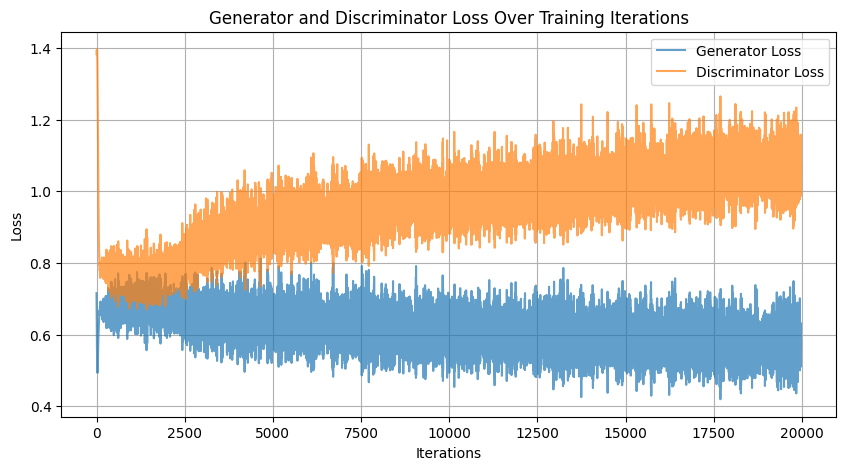

In [13]:
############################# TODO #############################
# Here, you should use the "G_losses", and "D_losses" in order to plot the "Loss Values Variation Diagram".

# YOUR CODE STARTS HERE

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss Over Training Iterations")
plt.plot(G_losses, label="Generator Loss", alpha=0.7)
plt.plot(D_losses, label="Discriminator Loss", alpha=0.7)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid("True")
plt.show()
# YOUR CODE ENDS HERE

## **Visualization:**

By using the "img_list" you can visualize the animation of changes that occurred during training.

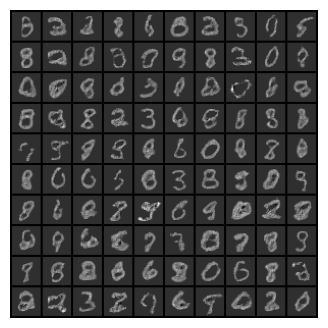

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(4, 4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.detach().cpu(), (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

#FID

In [41]:
preprocess = transforms.ToTensor()
checkpoint = torch.load('model_19000.pt')
model = checkpoint[0]
def save_real_images(dataset, num_images, folder='real_images'):
    if not os.path.exists(folder):
        os.makedirs(folder)

    for idx in range(num_images):
        image, _ = dataset[idx]
        save_image(image, os.path.join(folder, f'real_{idx}.png'))
mnist_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=preprocess)
save_real_images(mnist_dataset, 500)

In [42]:
def generate_images(model, num_images, folder='fake_images'):
    if not os.path.exists(folder):
        os.makedirs(folder)
    model.eval()
    for i in range(num_images):
        with torch.no_grad():
            noise = torch.randn(1, 64).to(device)
            generated_image = model(noise)
            save_image(generated_image, os.path.join(folder, f'fake_{i}.png'))
generate_images(model, 500)

In [2]:
from torchmetrics.image.fid import FrechetInceptionDistance
fake_images = torch.zeros(500,3,28,28)
real_images = torch.zeros(500,3,28,28)

for i in range(500):
  fake_images[i]  = torchvision.io.read_image(f'/content/fake_images/fake_{i}.png')
  real_images[i]  = torchvision.io.read_image(f'/content/real_images/real_{i}.png')

fid = FrechetInceptionDistance(feature=192, normalize=True)
# generate two slightly overlapping image intensity distributions

fid.update(real_images.type(torch.uint8), real=True)
fid.update(fake_images.type(torch.uint8), real=False)
fid.compute()

tensor(38.8508)
